In [4]:
# -*- coding: utf-8 -*-
import numpy as np
import pandas as pd
import datetime
import sys
import re
import gc
import glob

import os
HOME = os.path.expanduser('~')
sys.path.append(f"{HOME}/kaggle/data_analysis/library/")
import utils
from utils import logger_func, get_categorical_features, get_numeric_features, pararell_process
logger = logger_func()
pd.set_option('max_columns', 200)
pd.set_option('max_rows', 200)

#========================================================================
# Global Variable
#========================================================================

2018-11-08 22:48:22,871 utils 353 [INFO]    [logger_func] start 


In [5]:
# DatasetのPickle化
# train = pd.read_csv('../input/train.csv')
# test = pd.read_csv('../input/test.csv')
# utils.to_df_pkl(df=train, path='../input', fname='train')
# utils.to_df_pkl(df=test, path='../input', fname='test')
train = utils.read_df_pkl(path='../input/train*.p')
test = utils.read_df_pkl(path='../input/test*.p')

100%|██████████| 3/3 [00:00<00:00, 181.92it/s]


In [16]:
print(train.shape)
print(test.shape)

(1306122, 3)
(56370, 2)


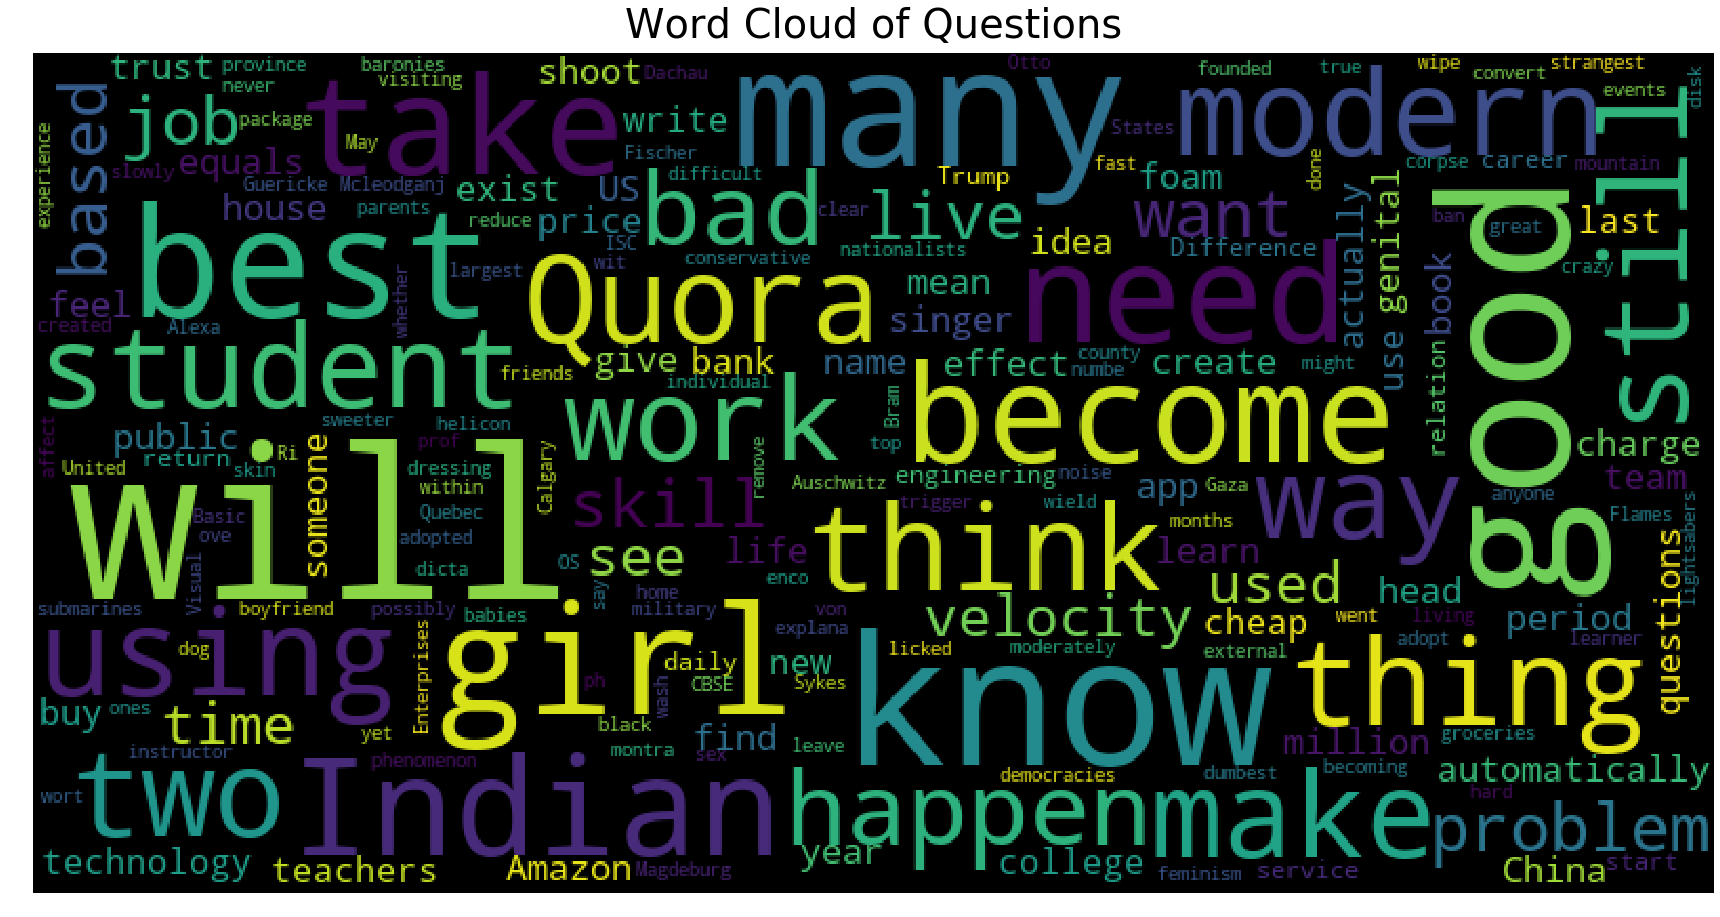

In [12]:
import json
import string
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics, ensemble, naive_bayes, linear_model
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(text, mask=None, max_words=200, max_font_size=100,
                   figure_size=(24.0, 16.0), title=None, title_size=40, image_color=False):
    
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    
    wordcloud = WordCloud(background_color='black',
                          stopwords = stopwords,
                          max_words = max_words,
                          max_font_size = max_font_size,
                          random_state = 1208,
                          width=800,
                          height=400,
                          mask = mask
                         )
    wordcloud.generate(str(text))
    
    plt.figure(figsize=figure_size)
    
    plt.imshow(wordcloud);
    plt.title(title, fontdict={'size': title_size, 'color': 'black', 'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    
plot_wordcloud(train['question_text'], title="Word Cloud of Questions")

In [72]:
from collections import defaultdict
train_1 = train[train["target"]==1]
train_0 = train[train["target"]==0]


## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    # *はリストを解除する.ここでは単語単位でリストに格納されており、
    # n_gramの数に応じて最初のインデックスが変わっていくので、1つずつインデックスのズレたリストがzipに入り、
    # n_gramの作成になっている
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(color=color,),
    )
    return trace


## Get the bar chart from sincere question ##
# n_gramの単位でワードカウント
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
        
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]        
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

## Get the bar chart from insincere questions ##
freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04,
                         subplot_titles=["Frequent words of sincere questions",
                                         "Frequent words of insincere questions" ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
py.iplot(fig, filename="word-plots")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [75]:
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'orange')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=2, vertical_spacing=0.04, horizontal_spacing=0.15,
                         subplot_titles=["Frequent bigrams of sincere questions",
                                        "Frequent bigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Bigram Count Plots")
py.iplot(fig, filename="word-plots")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]



In [78]:
freq_dict = defaultdict(int)
for sent in train_0["question_text"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(50), 'green')

freq_dict = defaultdict(int)
for sent in train_1["question_text"]:
    for word in generate_ngrams(sent, 3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(50), 'green')

# Creating two subplots
fig = tools.make_subplots(rows=1, cols=3, vertical_spacing=0.04, horizontal_spacing=0.15,
                         subplot_titles=["Frequent trigrams of sincere questions",
                                        "Frequent trigrams of insincere questions"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
py.iplot(fig, filename="word-plots")

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]



In [7]:
## Feature Engineering ##
train["num_words"] = train["question_text"].apply(lambda x: len(str(x).split()))
test["num_words"] = test["question_text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ## 
train["num_unique_words"] = train["question_text"].apply(lambda x: len(set(str(x).split())))
test["num_unique_words"] = test["question_text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train["num_chars"] = train["question_text"].apply(lambda x: len(str(x)))
test["num_chars"] = test["question_text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train["num_stopwords"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w in STOPWORDS ]))
test["num_stopwords"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w in STOPWORDS ]))

## Number of punctuations in the text ##
train["num_punctuations"] = train["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test["num_punctuations"] = test["question_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test["num_words_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train["num_words_lower"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))
test["num_words_lower"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.islower()]))

## Number of upper chars in the text ##
train["num_chars_upper"] = train["question_text"].apply(lambda x: len([w for w in str(x) if w.isupper()]))
test["num_chars_upper"] = test["question_text"].apply(lambda x: len([w for w in str(x) if w.isupper()]))

## Number of lower chars in the text ##
train["num_chars_lower"] = train["question_text"].apply(lambda x: len([w for w in str(x) if w.islower()]))
test["num_chars_lower"] = test["question_text"].apply(lambda x: len([w for w in str(x) if w.islower()]))

## Number of title case words in the text ##
train["num_words_title"] = train["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test["num_words_title"] = test["question_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train["mean_word_len"] = train["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test["mean_word_len"] = test["question_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

## Max length of the words in the text ##
train["max_word_len"] = train["question_text"].apply(lambda x: np.max([len(w) for w in str(x).split()]))
test["max_word_len"] = test["question_text"].apply(lambda x: np.max([len(w) for w in str(x).split()]))

## Min length of the words in the text ##
train["min_word_len"] = train["question_text"].apply(lambda x: np.min([len(w) for w in str(x).split()]))
test["min_word_len"] = test["question_text"].apply(lambda x: np.min([len(w) for w in str(x).split()]))

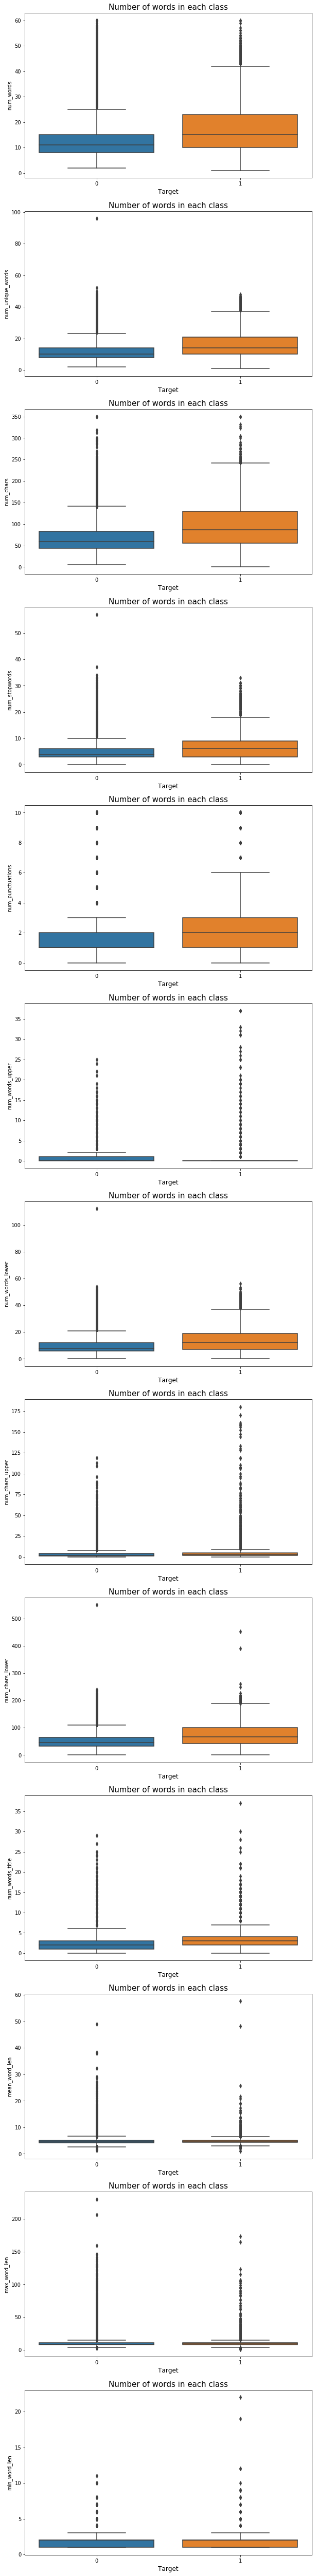

In [9]:
## Truncate some extreme values for better visuals ##
viz_train = train.copy()
viz_train["num_words"].loc[viz_train["num_words"]>60] = 60 # truncation for better visuals
viz_train["num_punctuations"].loc[viz_train["num_punctuations"]>10] = 10 # truncation for better visuals
viz_train["num_chars"].loc[viz_train["num_chars"]>350] = 350 # truncation for better visuals

feature_cols = [col for col in viz_train.columns if col.count('word') or col.count('num')]

f, axes = plt.subplots(len(feature_cols), 1, figsize=(10,7*len(feature_cols)))
# f, axes = plt.subplots(3, 1, figsize=(10,20))
for i, col in enumerate(feature_cols):
    sns.boxplot(x="target", y=col, data=viz_train, ax=axes[i])
    axes[i].set_xlabel("Target", fontsize=12)
    axes[i].set_title("Number of words in each class", fontsize=15)

# sns.boxplot(x='target', y="num_chars", data=viz_train, ax=axes[1])
# axes[1].set_xlabel("Target", fontsize=12)
# axes[1].set_title("Number of characters in each class", fontsize=15)

# sns.boxplot(x='target', y="num_punctuations", data=viz_train, ax=axes[2])
# axes[2].set_xlabel("Target", fontsize=12)
# axes[2].set_title("Number of punctuations in each class", fontsize=15)
plt.show()

### Baseline Model Logistic Regression

In [11]:
# Get the tfid
tfidf_vec = TfidfVectorizer(stop_words="english", ngram_range=(1,3))
tfidf_vec.fit_transform(train["question_text"].values.tolist() + test["question_text"].values.tolist())
train_tfidf = tfidf_vec.transform(train["question_text"].values.tolist())
test_tfidf = tfidf_vec.transform(test["question_text"].values.tolist())
print(train_tfidf)

  (0, 6406912)	0.298745442691
  (0, 6406911)	0.298745442691
  (0, 6406775)	0.207024563827
  (0, 6341375)	0.298745442691
  (0, 6341374)	0.298745442691
  (0, 6341211)	0.203519094776
  (0, 5361438)	0.298745442691
  (0, 5361437)	0.298745442691
  (0, 5361284)	0.208691772287
  (0, 5356636)	0.298745442691
  (0, 5356629)	0.161241511718
  (0, 2204670)	0.298745442691
  (0, 2204668)	0.279777610113
  (0, 2172302)	0.0928051358952
  (0, 53966)	0.212816133118
  (1, 7162590)	0.180376323051
  (1, 5828799)	0.314387652631
  (1, 5828791)	0.275354977737
  (1, 5827601)	0.091769131786
  (1, 2681659)	0.314387652631
  (1, 2681657)	0.251422202699
  (1, 2681267)	0.198857538295
  (1, 2445815)	0.314387652631
  (1, 2445814)	0.314387652631
  (1, 2444756)	0.151720554513
  :	:
  (1306120, 7467256)	0.291820103416
  (1306120, 7467245)	0.24739046486
  (1306120, 7458329)	0.113694236291
  (1306120, 6713389)	0.291820103416
  (1306120, 6713387)	0.227557312779
  (1306120, 6710777)	0.138128831406
  (1306120, 6294723)	0.2918201

In [14]:
Y = train["target"].values

def runModel(x_train, y_train, x_test, y_test, x2_test):
    model = linear_model.LogisticRegression(C=5., solver="sag")
    model.fit(x_train, y_train)
    y_pred = model.predict_proba(x_test)[:, 1]
    y2_pred = model.predict_proba(x2_test)[:, 1]
    return y_pred, y2_pred, model

print("Building model.")
score_list = []
pred_full_test = 0
# trainの長さのarrayを作り、val_idxを使って、該当indexにvalidationの結果を入れていく。賢い
pred_train = np.zeros([train.shape[0]])
kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=1208)
for trn_idx, val_idx in kfold.split(train):
    x_train, x_val = train_tfidf[trn_idx], train_tfidf[val_idx]
    y_train, y_val = Y[trn_idx], Y[val_idx]
    pred_y_val, pred_y_test, model = runModel(x_train, y_train, x_val, y_val, test_tfidf)
    pred_full_test = pred_full_test + pred_y_test
    pred_train[val_idx] = pred_y_val
    score_list.append(metrics.log_loss(y_val, pred_y_val))
    break

Building model.


In [17]:
for thresh in np.arange(0.1, 0.201, 0.01):
    thresh = np.round(thresh, 2)
    f1 = metrics.f1_score(y_val, (pred_y_val>thresh).astype(int))
    print(f"F1 score at threshold {thresh} is {f1}")

F1 score at threshold 0.1 is 0.5722679724015135
F1 score at threshold 0.11 is 0.5802945869077623
F1 score at threshold 0.12 is 0.5868821883742618
F1 score at threshold 0.13 is 0.5905086251573258
F1 score at threshold 0.14 is 0.5948306504849439
F1 score at threshold 0.15 is 0.5967481369534628
F1 score at threshold 0.16 is 0.5974351454395179
F1 score at threshold 0.17 is 0.5976352366128724
F1 score at threshold 0.18 is 0.5965441196996344
F1 score at threshold 0.19 is 0.5951119466757819
F1 score at threshold 0.2 is 0.5951571175256533


In [19]:
import eli5
eli5.show_weights(model, vec=tfidf_vec, top=100, feature_filter=lambda x: x != "<BIAS>")

Weight?,Feature
+19.594,castrated
+17.197,castrate
+16.983,democrats
+16.883,liberals
+16.498,muslims
+15.133,indians
+14.494,trump
+14.099,castration
+14.062,women
+13.955,americans
